# Pre-process EBSD patterns from an Al-Mn alloy

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

In [59]:
%matplotlib qt5

from datetime import date
import importlib_metadata
import os
from time import time

import dask
from diffpy.structure import Lattice, Structure
from diffsims.crystallography import ReciprocalLatticePoint
import hyperspy.api as hs
import kikuchipy as kp
import matplotlib.pyplot as plt
import numpy as np
from pyebsdindex import ebsd_index, pcopt
from orix import io, plot, sampling
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Rotation
from orix.vector import Vector3d


# Directories
dset_no = 3
dir_mp = "/home/hakon/kode/emsoft/emdata/crystal_data"
dir_data = f"/home/hakon/phd/data/p/prover/300c/{dset_no}"
dir_nordif = os.path.join(dir_data, "nordif")
dir_kp = os.path.join(dir_data, "kp")

# Data set specific parameters
cal_pats_al = {1: [10, 11, 12, 13, 14], 2: [0, 6, 7, 8, 9, 10, 11], 3: [9, 10, 11, 12, 13]}
pc0 = {1: (0.48, 0.82, 0.54), 2: (0.46, 0.85, 0.54), 3: (0.50, 0.77, 0.55)}

# Matplotlib
plt.rcParams["font.size"] = 12
savefig_kw = dict(bbox_inches="tight", pad_inches=0, dpi=150)

print("Run date: ", date.today())
print("\nSoftware versions\n------------------")
for pkg in [
    "dask",
    "diffpy.structure",
    "diffsims",
    "hyperspy",
    "kikuchipy",
    "matplotlib",
    "numpy",
    "pyebsdindex",
    "orix",
]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-03-28

Software versions
------------------
dask : 2022.3.0
diffpy.structure : 3.0.1
diffsims : 0.4.2
hyperspy : 1.6.5
kikuchipy : 0.5.7
matplotlib : 3.4.3
numpy : 1.21.5
pyebsdindex : 0.1rc1
orix : 0.8.2


# Pre-correction maps

Load data lazily (not into RAM)

In [46]:
s = kp.load(os.path.join(dir_kp, "patterns_dewrap.h5"), lazy=True)
sig_shape = s.axes_manager.signal_shape[::-1]
print(s.axes_manager)

<Axes manager, axes: (853, 853|96, 96)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    853 |      0 |       0 |     0.1 |     um 
               y |    853 |      0 |       0 |     0.1 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     96 |        |       0 |       1 |     um 
              dy |     96 |        |       0 |       1 |     um 


Mean intensity map

In [47]:
s_mean = s.mean(axis=s.axes_manager.signal_axes)
s_mean.compute()

[########################################] | 100% Completed | 17.1s


In [48]:
# Unprocessed map
map_mean1 = s_mean.data
plt.imsave(os.path.join(dir_kp, "maps_mean.png"), map_mean1, cmap="gray")

# Contrast stretched map
percentiles = np.percentile(map_mean1, q=(1, 99))
map_mean2 = kp.pattern.rescale_intensity(map_mean1, in_range=percentiles)
plt.imsave(os.path.join(dir_kp, "maps_mean_q1_q99.png"), map_mean2, cmap="gray")

Virtual backscatter electron images

In [5]:
vbse_gen = kp.generators.VirtualBSEGenerator(s)

RGB image

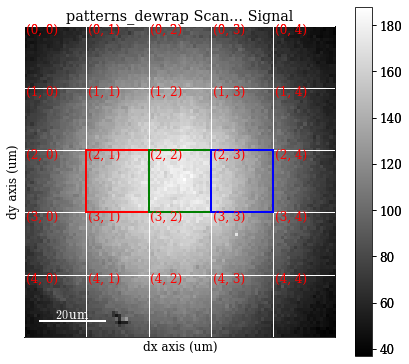

In [7]:
vbse_gen.grid_shape = (5, 5)
red = (2, 1)
green = (2, 2)
blue = (2, 3)
vbse_grid_plot = vbse_gen.plot_grid(
    rgb_channels=[red, green, blue], pattern_idx=(0, 0)
)
vbse_grid_plot._plot.signal_plot.figure.savefig(
    os.path.join(dir_kp, "vbse5x5_grid_plot.png"), **savefig_kw
)

In [8]:
vbse_rgb = vbse_gen.get_rgb_image(r=red, g=green, b=blue)
vbse_rgb.save(os.path.join(dir_kp, "vbse5x5_rgb.png"))

2022-03-28 17:09:20,625 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-03-28 17:09:31,686 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-03-28 17:09:37,257 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.


Overwrite '/home/hakon/phd/data/p/prover/300c/2/kp/vbse5x5_rgb.png' (y/n)?
 y


Grid

In [11]:
vbse_grid = vbse_gen.get_images_from_grid()

2022-03-28 16:37:19,677 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-03-28 16:37:25,176 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-03-28 16:37:30,235 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals.
2022-03-28 16:37:34,868 - hyperspy.io - WARNING - `signal_type='VirtualBSEImage'` not understood. See `hs.print_known_signal_types()` for a li

In [12]:
for idx in np.ndindex(vbse_grid.axes_manager.navigation_shape):
    plt.imsave(
        os.path.join(dir_kp, f"vbse5x5_y{idx[1]}x{idx[0]}.png"),
        arr=vbse_grid.inav[idx].data,
        cmap="gray"
    )

Background correction

In [17]:
s.remove_static_background()

In [18]:
s.remove_dynamic_background()

In [19]:
w = kp.filters.Window(window="gaussian", shape=(3, 3), std=1)
s.average_neighbour_patterns(window=w)

In [20]:
t0 = time()
s.save(os.path.join(dir_kp, "pattern_sda.h5"))
print((time() - t0) / 60, "min")

6.728586169083913 min


## Pre-indexing maps

In [13]:
s = kp.load(os.path.join(dir_kp, "pattern_sda.h5"), lazy=True)
print(s.axes_manager)

<Axes manager, axes: (919, 919|96, 96)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |    919 |      0 |       0 |     0.1 |     um 
               y |    919 |      0 |       0 |     0.1 |     um 
---------------- | ------ | ------ | ------- | ------- | ------ 
              dx |     96 |        |       0 |       1 |     um 
              dy |     96 |        |       0 |       1 |     um 


In [29]:
iq = s.get_image_quality()
adp = s.get_average_neighbour_dot_product_map()

In [27]:
plt.imsave(os.path.join(dir_kp, "maps_iq.png"), arr=iq, cmap="gray")
plt.imsave(os.path.join(dir_kp, "maps_adp.png"), arr=adp, cmap="gray")

## Projection center from PyEBSDIndex

Load calibration patterns

In [49]:
s_cal0 = kp.load(os.path.join(dir_nordif, "Setting.txt"))
sig_shape_cal = s_cal0.axes_manager.signal_shape[::-1]

In [50]:
s_cal0.remove_static_background()
s_cal0.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.1s
Removing the dynamic background:
[########################################] | 100% Completed |  0.1s


In [51]:
s_cal0.plot()

Extract Al calibration patterns

In [55]:
s_cal = kp.signals.EBSD(s_cal0.data[cal_pats_al[dset_no]])
s_cal.axes_manager[0].name = "x"
nav_size = s_cal.axes_manager.navigation_size

Extract relevant metadata

In [56]:
md_sem = s_cal0.metadata.Acquisition_instrument.SEM
md_ebsd = md_sem.Detector.EBSD
sample_tilt = md_ebsd.sample_tilt  # Degrees
camera_tilt = md_ebsd.azimuth_angle  # Degrees
energy = md_sem.beam_energy  # kV

Generate an indexer instance with PyEBSDIndex for easy storage of relevant
parameters used in projection center (PC) optimization

In [57]:
indexer = ebsd_index.EBSDIndexer(
    phaselist=["FCC"],
    vendor="EDAX",
    PC=None,
    sampleTilt=sample_tilt,
    camElev=camera_tilt,
    patDim=sig_shape_cal[::-1]
)

Find PC from single pattern using an initial guess, as a test

In [60]:
pc0_i = pc0[dset_no]
print(pc0_i)

pc = pcopt.optimize(s_cal.inav[0].data, indexer, PC0=pc0_i)
print(pc)

(0.5, 0.77, 0.55)
[0.49562909 0.77346785 0.55503443]


Find PC from all patterns

In [61]:
pcs = np.zeros((nav_size, 3))
for i in range(nav_size):
    pcs[i] = pcopt.optimize(s_cal.inav[i].data, indexer, PC0=pc0_i)
print(pcs)

pc = pcs.mean(axis=0)
print(pc)

[[0.49562909 0.77346785 0.55503443]
 [0.49913684 0.78269842 0.54435737]
 [0.498329   0.77598661 0.54274758]
 [0.50118166 0.76071044 0.54318905]
 [0.49353876 0.77587649 0.55036185]]
[0.49756307 0.77374796 0.54713806]


Index calibration patterns to check PCs

In [62]:
data = indexer.index_pats(
    patsin=s_cal.data,
    patstart=0,
    npats=-1,
    clparams=None,
    PC=pc,
)
rot = Rotation(data[0]["quat"][0])

In [63]:
detector = kp.detectors.EBSDDetector(
    shape=sig_shape_cal,
    pc=pc,  # Use average PC to reduce potential for single error upon refinement
    sample_tilt=sample_tilt,
    tilt=camera_tilt,
    convention="edax",
)
detector

EBSDDetector (240, 240), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.498, 0.226, 0.547)

Load Al master pattern to use in PC refinement and to extract the Al crystal structure

In [64]:
mp = kp.load(
    os.path.join(dir_mp, "al", "al_mc_mp_20kv.h5"),
    projection="lambert",
    energy=energy,
    hemisphere="north",
)
mp.phase.name = "al"

Inspect geometrical simulations

In [65]:
rlp = ReciprocalLatticePoint(phase=mp.phase, hkl=((1, 1, 1), (2, 0, 0), (2, 2, 0), (3, 1, 1)))
rlp2 = rlp.symmetrise()
simgen = kp.generators.EBSDSimulationGenerator(detector=detector, phase=rlp.phase, rotations=rot)
geosim = simgen.geometrical_simulation(reciprocal_lattice_point=rlp2)
markers = geosim.as_markers(pc=False, bands=True, zone_axes_labels=True, zone_axes=False)

#del s_cal.metadata.Markers
s_cal.add_marker(marker=markers, plot_marker=False, permanent=True)
s_cal.plot(navigator=None)

Refine results from PyEBSDIndex

In [66]:
xmap = CrystalMap(rotations=rot, phase_list=PhaseList(mp.phase))

# First refine orientations, then projection centers
ref_kwargs = dict(detector=detector, master_pattern=mp, energy=energy)
xmap_refined = s_cal.refine_orientation(xmap=xmap, **ref_kwargs)
_, detector_ref = s_cal.refine_projection_center(xmap=xmap_refined, **ref_kwargs)

Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'method': 'Nelder-Mead'}
Refining 5 orientation(s):
[########################################] | 100% Completed |  2.3s
Refinement speed: 2 patterns/s
Refinement information:
	Local optimization method: Nelder-Mead (minimize)
	Keyword arguments passed to method: {'method': 'Nelder-Mead'}
Refining 5 projection center(s):
[########################################] | 100% Completed |  1.8s
Refinement speed: 2 patterns/s


Check geometrical simulations of refined orientations and PCs

In [67]:
simgen = kp.generators.EBSDSimulationGenerator(
    detector=detector_ref, phase=mp.phase, rotations=xmap_refined.rotations,
)
geosim = simgen.geometrical_simulation(reciprocal_lattice_point=rlp2)
markers = geosim.as_markers(pc=False, bands=True, zone_axes_labels=True, zone_axes=False)

del s_cal.metadata.Markers
s_cal.add_marker(marker=markers, plot_marker=False, permanent=True)
s_cal.plot(navigator=None)

In [68]:
np.savetxt(
    os.path.join(dir_kp, "cal_pcs.txt"),
    np.column_stack((cal_pats_al[dset_no], detector_ref.pc)),
    fmt="%i %.12f %.12f %.12f",
    header="Cal. pattern, PC (x, y, z) in Bruker's convention"
)

## Dictionary indexing

Done in a separate notebook using the above obtained PC.

## Refinement

Done in a separate notebook using the DI results.